# Introduction - Karhunen–Loève Image Projection

To image planets around other stars, we are usually impeded by the brightness of the star relative to the planet. Therefore, clever schemes to remove starlight have been the cornerstone of exoplanet direct imaging. The state of the art in starlight subtraction advanced dramatically in 2012 with the publication in the Astrophysical Journal Letters of ["Detection and Characterization of Exoplanets and Disks Using Projections on Karhunen-Loève Eigenimages"](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract) by Rémi Soummer, Laurent Pueyo, and James Larkin.

In their paper, they explain how the eigenvectors of the covariance matrix of a reference set of star images may be used to estimate (and subtract) starlight in a new observation. Almost simultaneously, Adam Amara and Sascha P. Quanz published their paper ["PYNPOINT: an image processing package for finding exoplanets"](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract) in the Monthly Notices of the Royal Astronomical Society, describing a closely related technique.

Though the specific notation and algorithm proposed differed, the two papers applied the method of [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to starlight subtraction. Principal component analysis goes by many names, as the following quote from the Wikipedia page demonstrates:

> Depending on the field of application, it is also named the discrete Karhunen–Loève transform (KLT) in signal processing, the Hotelling transform in multivariate quality control, proper orthogonal decomposition (POD) in mechanical engineering, singular value decomposition (SVD) of X (Golub and Van Loan, 1983), eigenvalue decomposition (EVD) of XTX in linear algebra, factor analysis (for a discussion of the differences between PCA and factor analysis see Ch. 7 of Jolliffe's Principal Component Analysis), Eckart–Young theorem (Harman, 1960), or empirical orthogonal functions (EOF) in meteorological science, empirical eigenfunction decomposition (Sirovich, 1987), empirical component analysis (Lorenz, 1956), quasiharmonic modes (Brooks et al., 1988), spectral decomposition in noise and vibration, and empirical modal analysis in structural dynamics.

These different names generally come with minor mathematical differences, such as whether means are subtracted along one dimension or another, or eigenimages are obtained from the eigenvectors of the image-to-image covariance matrix instead of from the singular vectors of the data matrix, but we will not attempt to cover all possible variants—just the description in Soummer *et al.*

There are two key aspects to these algorithms:

  - identifying the eigenimages, and
  - truncation as noise suppression.

As we will see, a set of images in an array of $K \times n_\text{pix} \times n_\text{pix}$ elements can be transformed into an array of $K \times n_\text{pix} \times n_\text{pix}$ **eigenimages**. These eigenimages are ordered such that the first image captures most of the variance in the dataset (i.e. the average image), with the successive components capturing variance in the residuals after previous components have been removed.

The **truncation** step relies on the assumption (which can be checked empirically) that, in a set of $K$ observations contaminated with noise transformed into $K$ corresponding eigenimages, only the first $K_\text{klip} < K$ of those eigenimages will capture useful information for subtracting starlight from a new image outside the reference set, while the rest capture only noise.

The following code sample follows the algorithm as laid out in Soummer *et al.*, following their notation (within the constraints of Python).

In the following, $I_\psi$ means a PSF intensity pattern realized for a telescope state $\psi$. We're trying to compute $\hat{I}_\psi$, an approximation of the PSF intensity pattern, in hopes that subtracting it will reveal a faint astronomical signal (which they call $A$). Our observed frames $T$ are combinations of the PSF and an astronomical signal: $T = I_\psi + A$. If our approximation is good, we subtract it off like so: $T - \hat{I}_\psi = A$, recovering the astronomical signal of interest. (This is a simplification of what is stated in *Soummer et al.* since, as we will see, $A$ will not be recovered perfectly in general.)

To begin, we import our libraries in the usual fashion, and make some adjustments for attractive plots:

In [231]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage

matplotlib.rcParams.update({
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'font.family': 'serif',
})

# Get the data

[These data](https://github.com/carlgogo/VIP_extras/tree/master/datasets) of $\beta$ Pictoris from [NACO](http://www.eso.org/sci/facilities/paranal/decommissioned/naco.html) were made available by Carlos Gomez Gonzalez, author of [VIP](https://github.com/vortex-exoplanet/VIP) (an image processing package implementing this and other algorithms). Unlike most exoplanet direct imaging data, they have [a planet](https://en.wikipedia.org/wiki/Beta_Pictoris_b) in them, which makes them great for this demo.

Download [naco_betapic_preproc.npz](https://github.com/carlgogo/VIP_extras/raw/master/datasets/naco_betapic_preproc.npz) and save it to the current directory, or just run this cell:

In [235]:
!curl -OL https://github.com/carlgogo/VIP_extras/raw/master/datasets/naco_betapic_preproc.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  1 2177k    1 32768    0     0  21998      0  0:01:41  0:00:01  0:01:40 21998
100 2177k  100 2177k    0     0  1372k      0  0:00:01  0:00:01 --:--:-- 21.8M


Load the NumPy archive and assign the data cube to `frames_full`.

In [237]:
naco_betapic_preproc = np.load('./naco_betapic_preproc.npz')
frames_full = naco_betapic_preproc['cube']

Peek at the mean frame. These data were taken with a [vortex coronagraph](https://www.eso.org/sci/publications/messenger/archive/no.152-jun13/messenger-no152-8-13.pdf), so don't be surprised that the star looks more like a donut.

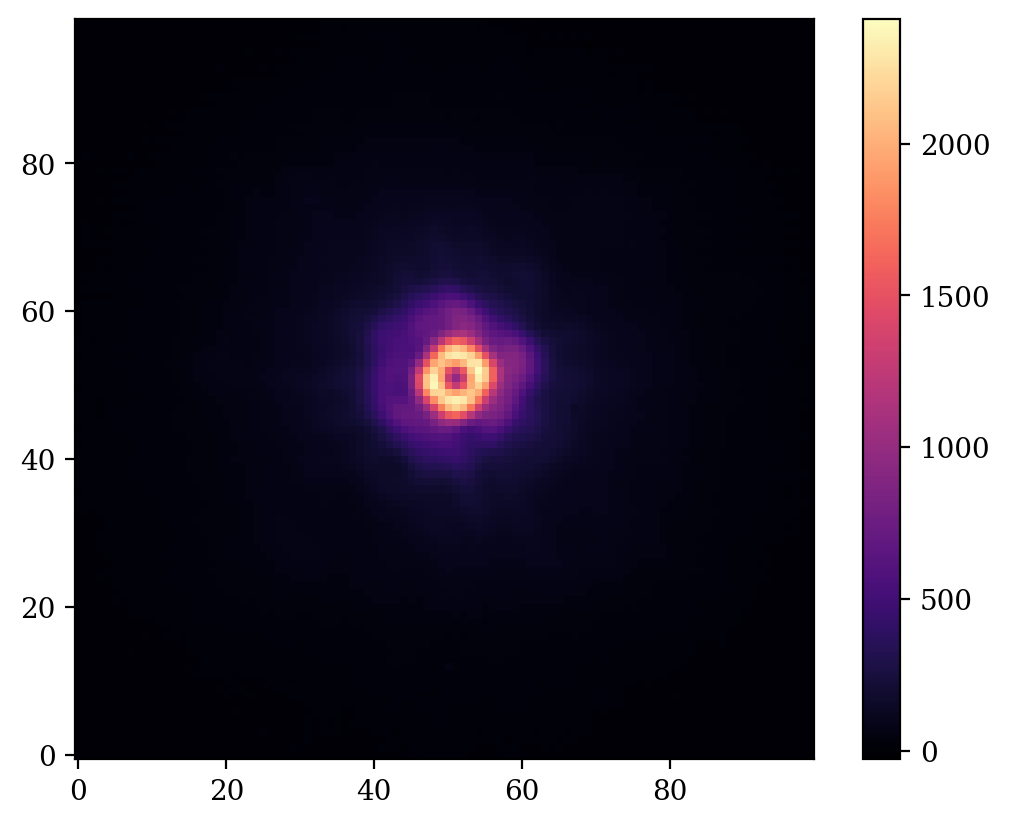

In [239]:
plt.imshow(np.average(frames_full, axis=0))
plt.colorbar()

# The Preliminaries

To save a lot of extra typing, we will rearrange our images into image vectors first. Instead of a 3D cube where the first index is frame number, second is pixel Y index, and third is pixel X index, we now have a 2D matrix where the first (row) index is frame number and the second (column) index is an **unwrapped** pixel index between 0 and ((X pixels) * (Y pixels) - 1).

In [241]:
image_shape = frames_full.shape[1], frames_full.shape[2]
frame_vecs_full = frames_full.reshape(frames_full.shape[0], image_shape[0] * image_shape[1])

In section 2.1 of the paper, an $N$ pixel [PSF](https://en.wikipedia.org/wiki/Point_spread_function) intensity pattern  (star image) is written $I_\psi(n)$, where $n$ denotes the $n$th pixel in the image and $\psi$ is a symbolic placeholder for any properties of the imaging system that could change. (In practice, we can't—and don't need to—compute $\psi$, but it lets us refer to different realizations of the PSF $\{ I_{\psi_0}, I_{\psi_1}, ..., I_{\psi_k} \}$.)

The authors use $n \in [1, N]$ as the unwrapped pixel index (eq. 1). We count from 0 in Python / NumPy, making it $n \in [0, N)$ when used in the code. Unless explicitly stated, 1-based indices in equations in the text correspond to 0-based indices in the code. This makes both read more naturally, and the infrequency of explicit indexing in well-written NumPy code should (I hope) prevent this from being a source of confusion.

We will need this N later, so pull it out of the shape and put it in a variable.

In [243]:
N = frame_vecs_full.shape[1]

# The Algorithm

Karhunen-Loève Image Projection (KLIP) consists of the following steps.

## Step 1: Subtract image means and Select target/reference images

We subtract the means from all images before separating them into a target image and set of reference images. By averaging along the column axis of our matrix of unwrapped images, we get the mean value in each image across all its pixels. (There's some ambiguity in the original paper as to which direction this mean should go—along an image or down a pixel—but one of the directions produces the correct answer.)

In [246]:
mean_vec = np.average(frame_vecs_full, axis=1)
mean_vec.shape

(61,)

In [247]:
frame_vecs_meansub = frame_vecs_full - mean_vec[:,np.newaxis]

For no particular reason, we select frame 30 (0-indexed) as the target image $T(n)$ and the rest of the frames form the set of references $R_k(n)$.

In [249]:
target = frame_vecs_meansub[30]
reference = np.delete(frame_vecs_meansub, 30, axis=0)

target.shape, reference.shape

((10000,), (60, 10000))

To index into the reference set of PSFs $R_k$ for $k \in [0, K)$ we'll need the number of references, $K$, so stash it in a variable.

In [251]:
K = reference.shape[0]

## Step 2: Compute the Karhunen-Loève transform

Each image vector is 10,000 elements, but we have only $K = 60$ reference images. To have a hope of accurately subtracting starlight from a target image that our algorithm hasn't seen, we must find a low-dimensional representation (≤60) that can reproduce a good approximation of the target $T$ from our 60 reference images $R_k$.

We could try finding the dot product of our target image vector with each reference image vector, but our images are not orthogonal (indeed, we expect them to be largely the same).

The Karhunen-Loève transform creates a basis set of orthogonal eigenimages which is "optimal". The sense in which it is optimal is in how it may be truncated: it is an "energy compacting" basis. The first KL basis vector explains the greatest part of the variance in the references, the second explains the next-greatest, and so on. Thus, removing (truncating) basis vectors from the end of the transform basis still leaves a basis set that reproduces a particular realization of the PSF $I_\psi$ with the least mean squared error [(Proof Here)](https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem#The_Karhunen%E2%80%93Lo%C3%A8ve_expansion_minimizes_the_total_mean_square_error).

This is the core of KLIP, and is really a multi-step process. Soummer _et al._ define the $k$th member of the KL basis  for the set of reference PSFs $\{ R_k(n) \}_{k=1...K}$ in their equation 5:

> Eq. 5: $$Z_k^\text{KL} (n) = \frac{1}{\sqrt{\Lambda_k}} \sum_{p = 1}^{K} c_k(\psi_p) R_p(n)
$$
> where the vectors $C_k = [c_k(\psi_1) ... c_k(\psi_K)]$ are the eigenvectors of the $K$-dimensional covariance matrix $E_{RR}$ of the $R_k(n)$ references over S, and ${\Lambda}_{k=1...K}$ are its eigenvalues.

So, before we can compute the transform in eq. 5, we must construct the covariance matrix $E_{RR}$ of the references. They define it in their equation 6:

> Eq. 6:
> $$ E_{RR}[i, j] = \sum_{n=1}^{N_S} R_i(n) R_j(n)$$

In Equation 6, $N_S$ is the number of pixels in the search region $S$. Since our search region is the entire image, $N_S = N$. NumPy includes a built-in covariance function, which we can call on our matrix of reference image vectors.

**Note:** NumPy divides the result by $N - 1$, so to match the definition of $E_{RR}$ in the paper we must in turn *multiply* the covariance matrix by $N - 1$.

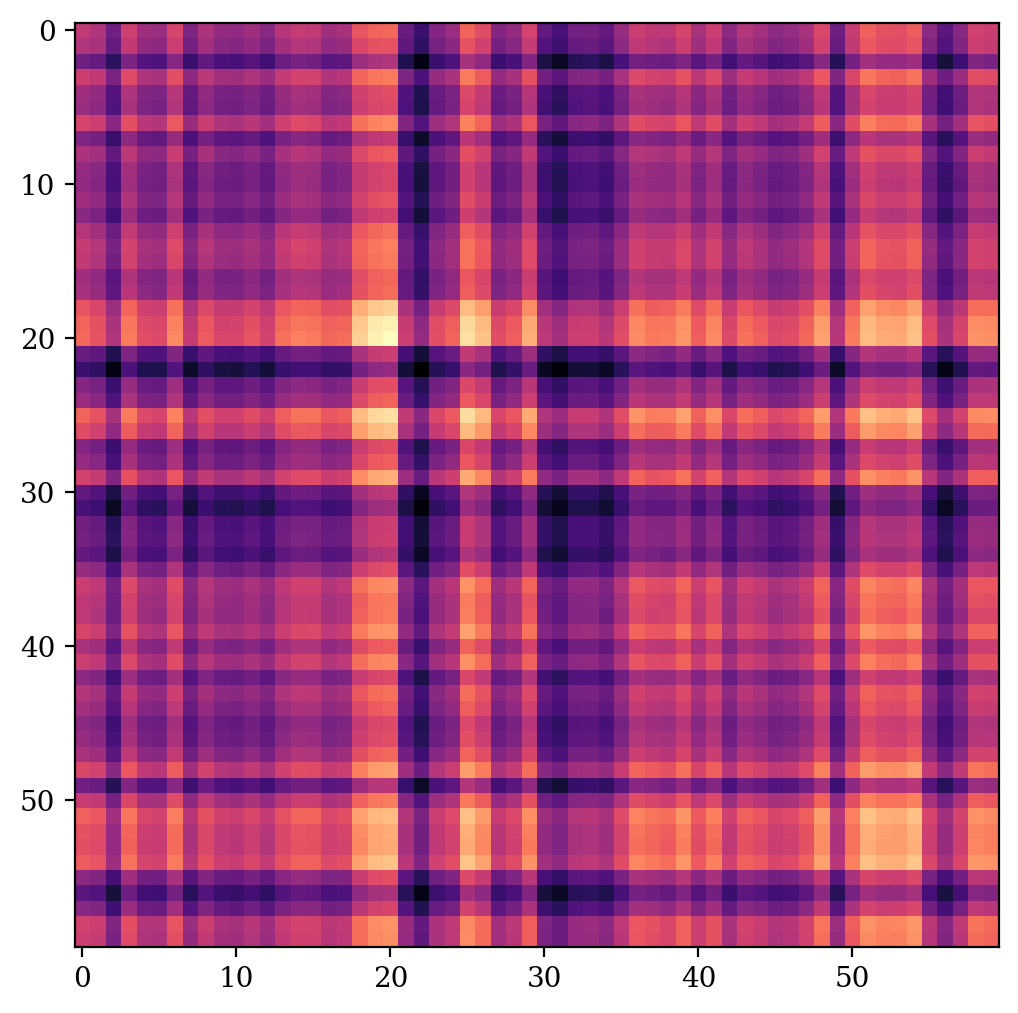

In [253]:
E = np.cov(reference) * (N - 1)
plt.figure(figsize=(6,6))
plt.imshow(E, origin='upper')

We could have just as easily computed it ourselves by multiplying $R$ and $R^T$. (In fact, this should be ever-so-slightly faster.)

In [255]:
np.allclose(E, reference @ reference.T) # '@' performs matrix multiplication (dot product)

True

The next prerequisite for evaluating eq. 5 is the vectors $C_k = [c_k(\psi_1) ... c_k(\psi_K)]$. These are the eigenvectors of the covariance matrix we just computed, which by virtue of it being symmetric, can be solved for with `numpy.linalg.eigh`.

We also plot the resulting eigenvalues in the order returned to reveal an important detail:

(60, 60)

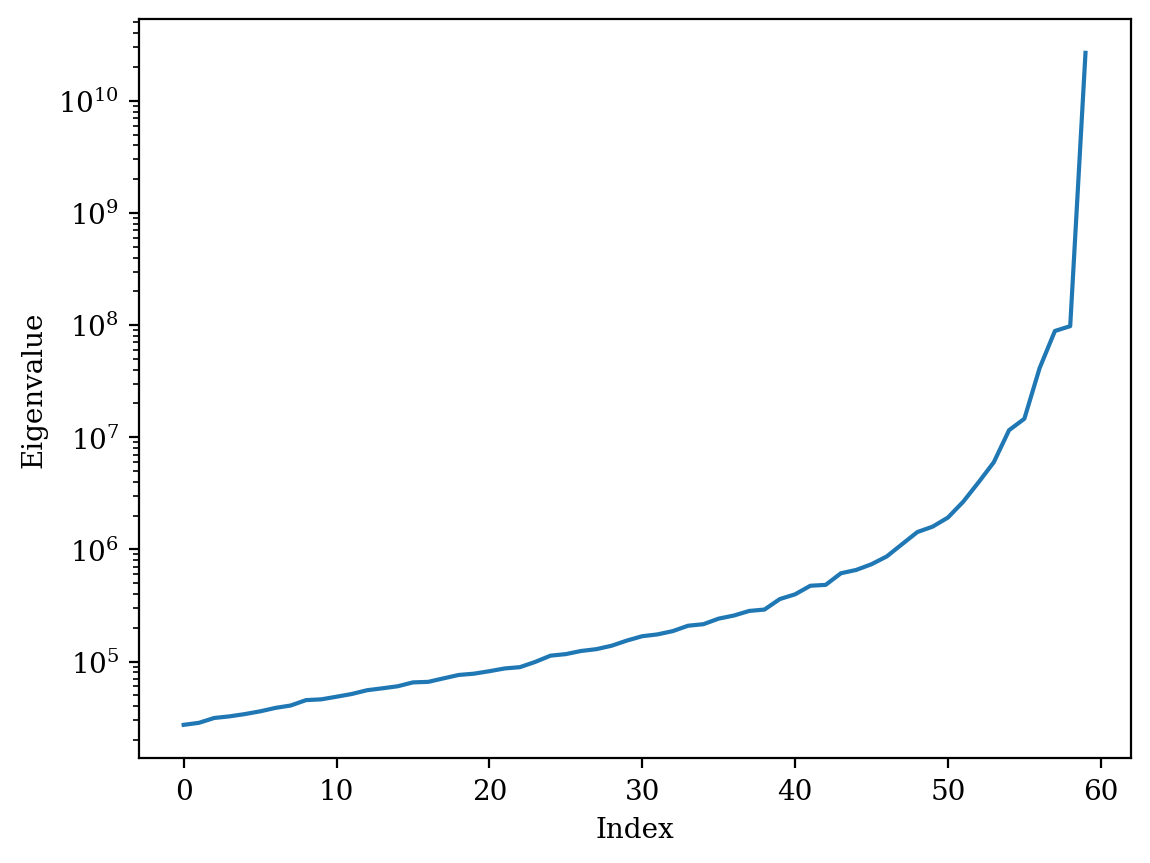

In [257]:
lambda_values_out, C_out = np.linalg.eigh(E)
plt.plot(lambda_values_out)
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
C_out.shape

The authors' equation 7 restates the definition of eigenvalue and eigenvector...

> $$ E_{RR} \cdot C_k = \Lambda_k C_k$$

... with a hint about indexing: 

> $$ \Lambda_1 > \Lambda_2 > ... > \Lambda_K.$$

To match this convention, reverse both the eigenvectors (arranged in columns, therefore `axis=1`) and the eigenvalues:

In [259]:
lambda_values = np.flip(lambda_values_out)
C = np.flip(C_out, axis=1)

Finally, we are able to evaluate equation 5 to compute the Karhunen-Loève transform of the reference PSFs.

> Eq. 5: $$Z_k^\text{KL} (n) = \frac{1}{\sqrt{\Lambda_k}} \sum_{p = 1}^{K} c_k(\psi_p) R_p(n)
$$

where $c_k(\psi_p)$ is (confusingly, for me) the $p$-th entry in the $k$-th column of $C$. And note that $(n)$ indexes a particular pixel value in the unwrapped image (or eigenimage) on both sides of the equation, so we can use NumPy broadcasting to treat a whole image at a time.

The following code calculates $Z^\text{KL} = [Z_1^\text{KL} ... Z_K^\text{KL}]$. For clarity, aside from the pixel index $n$, I'm just using (slow) Python loops for now instead of NumPy operations. Again, our indices will range from $p = 0$ to $p = K - 1$ and from $k = 0$ to $k = K - 1$ to match Python indexing.

In [261]:
Z_KL_slow = np.zeros((N, K))
for k in range(K):
    for p in range(K):
        Z_KL_slow[:,k] += (C[p,k] * reference[p]) / np.sqrt(lambda_values[k])
Z_KL_slow.shape

(10000, 60)

Now we can see what the KL transform basis thinks are the dominant modes in this dataset:

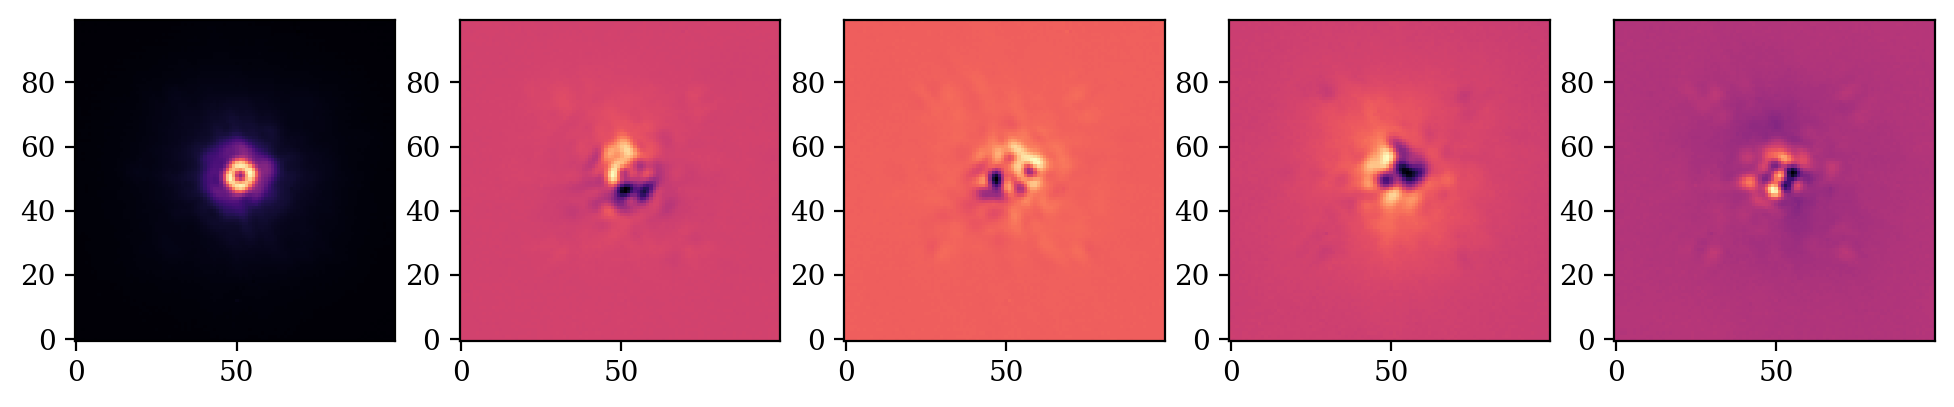

In [263]:
Z_KL_slow_images = Z_KL_slow.T.reshape((reference.shape[0],) + image_shape)
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(Z_KL_slow_images[i])

As expected, the stellar PSF is not stable across the frames in our reference set, with the dominant contributor to the variation being [atmospheric seeing](https://en.wikipedia.org/wiki/Astronomical_seeing)-induced aberration and speckles. These eigenimages capture the most common kinds of aberration found in our reference set.

The observant reader will notice that the summation in equation 5 looks a lot like a dot-product. We're summing along an index $p$, which indexes into the row of a particular eigenvector and the column of a particular reference PSF.

In other words, the vector of the $n$th pixels $n \in [1,N]$ of eigenimage $Z_k^\text{KL}$ is given by 

$$
\begin{align*}
\begin{bmatrix}
    Z_k^\text{KL}(1) \\
    \vdots \\
    Z_k^\text{KL}(N)
\end{bmatrix}_{1 \times N}
&= 
\begin{bmatrix}
    \frac{1}{\sqrt{\Lambda_k}} (C_{p=1,k} R_{p=1,n=1} + ... + C_{p=K,k} R_{p=K,n=1}) \\
    \vdots \\
    \frac{1}{\sqrt{\Lambda_k}} (C_{p=1,k} R_{p=1,n=K} + ... + C_{p=K,k} R_{p=K,n=K})
\end{bmatrix}
\end{align*}
$$

where I've written indices into the $C$ and $R$ matrices as row, column subscripts to emphasize that the $k$th KL mode uses the values of the $k$th column of $C$ and the entire $R$ matrix.

If you're like me, this is easier to explain if we pull it apart and show $C$ and $R$ as block matrices. We normally think of eigenvectors indexed by column. Our reference image-vectors are arranged in rows. (The matrix shape is noted in row $\times$ column subscripts.)

$$
\begin{align*}
C = \begin{bmatrix}
| & ... & | \\
C_1 & ... & C_{K} \\
| & ... & | \\
\end{bmatrix}_{K \times K}
& &
R = \begin{bmatrix}
— & R_1 & — \\
 & \vdots & \\
 — & R_K & — \\
\end{bmatrix}_{K \times N}
\end{align*}
$$

$Z_1^\text{KL}$, the first KL basis vector, is then given by 
$$
Z_1^\text{KL} = \frac{1}{\sqrt{\Lambda_1}} \begin{bmatrix}
    — & C_1 & — \\
\end{bmatrix} \begin{bmatrix}
    — & R_1 & — \\
     & \vdots & \\
     — & R_K & — \\
\end{bmatrix} =
\frac{1}{\sqrt{\Lambda_k}} \begin{bmatrix}
    — & C_1 R & — \\
\end{bmatrix}_{1 \times N}
$$

To construct the basis, then, we want
$$
    Z^\text{KL} = \begin{bmatrix}
| & ... & | \\
C_1 R \Lambda_1^{-1/2} & ... & C_K R \Lambda_K^{-1/2}\\
| & ... & | \\
\end{bmatrix}_{K \times N}
$$

to apply the scaling we need to rescale every element in $C_K$ by the corresponding $\Lambda_k^{-1/2}$, so call $X$ the diagonal matrix whose entries are $\Lambda_1^{-1/2}, ..., \Lambda_K^{-1/2}$.

$$
X = \begin{bmatrix}
\Lambda_1^{-1/2} & & 0\\
& \ddots & \\
0 & & \Lambda_K^{-1/2}
\end{bmatrix}_{K \times K}
$$

Then we use $(C X)^T$ to construct $(Z_\text{KL})^T$

$$
\begin{align*}
(Z^\text{KL})^T = (C X)^T R = \begin{bmatrix}
— & C_1 R \Lambda_1^{-1/2} & — \\
  &  \vdots & \\
— & C_K R \Lambda_K^{-1/2} & — \\
\end{bmatrix}_{N \times K}
\end{align*}
$$

so that
$$
\begin{align*}
Z^\text{KL} = ((C X)^T R)^T = \begin{bmatrix}
| & ... & | \\
C_1 R \Lambda_1^{-1/2} & ... & C_K R \Lambda_K^{-1/2}\\
| & ... & | \\
\end{bmatrix}.
\end{align*}
$$

After sorting out the repeated transpositions and reordering, we have

$$
    Z^\text{KL} =  R^T ((C X)^T)^T = R^T (C X)
$$

and can express the above doubly-nested loop in a single line of NumPy matrix algebra:

In [271]:
Z_KL = reference.T @ (C * np.power(lambda_values, -1/2))

Compare to the other version (using `atol` and `rtol` to account for numerical noise):

In [273]:
np.allclose(Z_KL_slow, Z_KL, atol=1e-6, rtol=1e-4)

True

## Step 3: Truncate the basis set

All Soummer _et al._ say in this step is to "choose a number of modes $K_\text{klip}$ to keep in the  estimate of $\hat{I}_{\psi_0}(n)$".

While simple in principle, in practice this is chosen by adjusting $K_\text{klip}$ such that the signal-to-noise ratio of a source is optimized.

Why truncate instead of keeping all 60 KL basis vectors?

When your references are images of totally different targets and you know ahead of time that they don't contain anything but $I_\psi$, the intensity pattern for a particular combination of telescope and conditions, it's less important! There is a risk of [overfitting](https://en.wikipedia.org/wiki/Overfitting), but the same property that allows us to explain most of the signal with only a few modes means that modes representing pure noise won't influence the reconstruction much.

Ground-based observations employing [angular differential imaging](http://dx.doi.org/10.1086/500401) (like this example) are another matter, as the target and reference are generally images of the same star (potentially combined with other astrophysical signal, like an exoplanet or disk), under the same conditions, varying only the rotation of the field. After subtracting the stellar PSF, the images are then rotated to a common orientation before combining, hopefully revealing an astrophysical signal that was mostly uncorrelated with the stellar PSF.

Under those circumstances, even when separating your target from your reference image, faint astrophysical sources near the star in one reference image may overlap their position in the target image—causing them to be mostly or entirely removed by KLIP.

While we will see the effects of varying $K_\text{klip}$ on the end product later, for now let's set it at 30.

In [276]:
K_klip = 30

## Step 4: Estimate the PSF from its projection onto eigenimages

To find $\hat{I}_{\psi_0}$, the best estimate of $I_{\psi_0}$ (the stellar PSF contribution to the target), we project our target $T$ onto each of the eigenimages in the KL basis to find that eigenimage's contribution to $T$, then multiply that by the eigenimage to obtain the pixel values and sum them.

The authors express $\hat{I}_{\psi_0}$ as follows in equation 8:

$$
    \hat{I}_{\psi_0}(n) = \sum_{k=1}^{K_\text{klip}} \langle T, Z_k^\text{KL} \rangle_S Z_k^\text{KL}(n)
$$

where $\langle T, Z_k^\text{KL} \rangle_S$ signifies the inner product over the search zone $S$ (in our case, the whole image).

Let us first construct `Z_KL_truncated`, which contains only the first `K_klip` eigenimages.

In [279]:
Z_KL_truncated = Z_KL[:,:K_klip]

Each column of $Z_k^\text{KL}$ is an eigenimage, and the projection of $T$ along that eigenimage is just a simple dot product:

$$
    \langle T, Z_k^\text{KL} \rangle = Z_k^\text{KL} \cdot T
$$

which we then multiply by the eigenimage to get its contribution to $\hat{I}_{\psi_0}$. Writing the above summation with a slow Python loop, we get:

In [281]:
Ihat_psi0_slow = np.zeros(N)
for k in range(K_klip):
    projection = np.dot(Z_KL_truncated[:,k], target)
    Ihat_psi0_slow += projection * Z_KL_truncated[:,k]

Let's compare $\hat{I}_{\psi_0}$ to $T$:

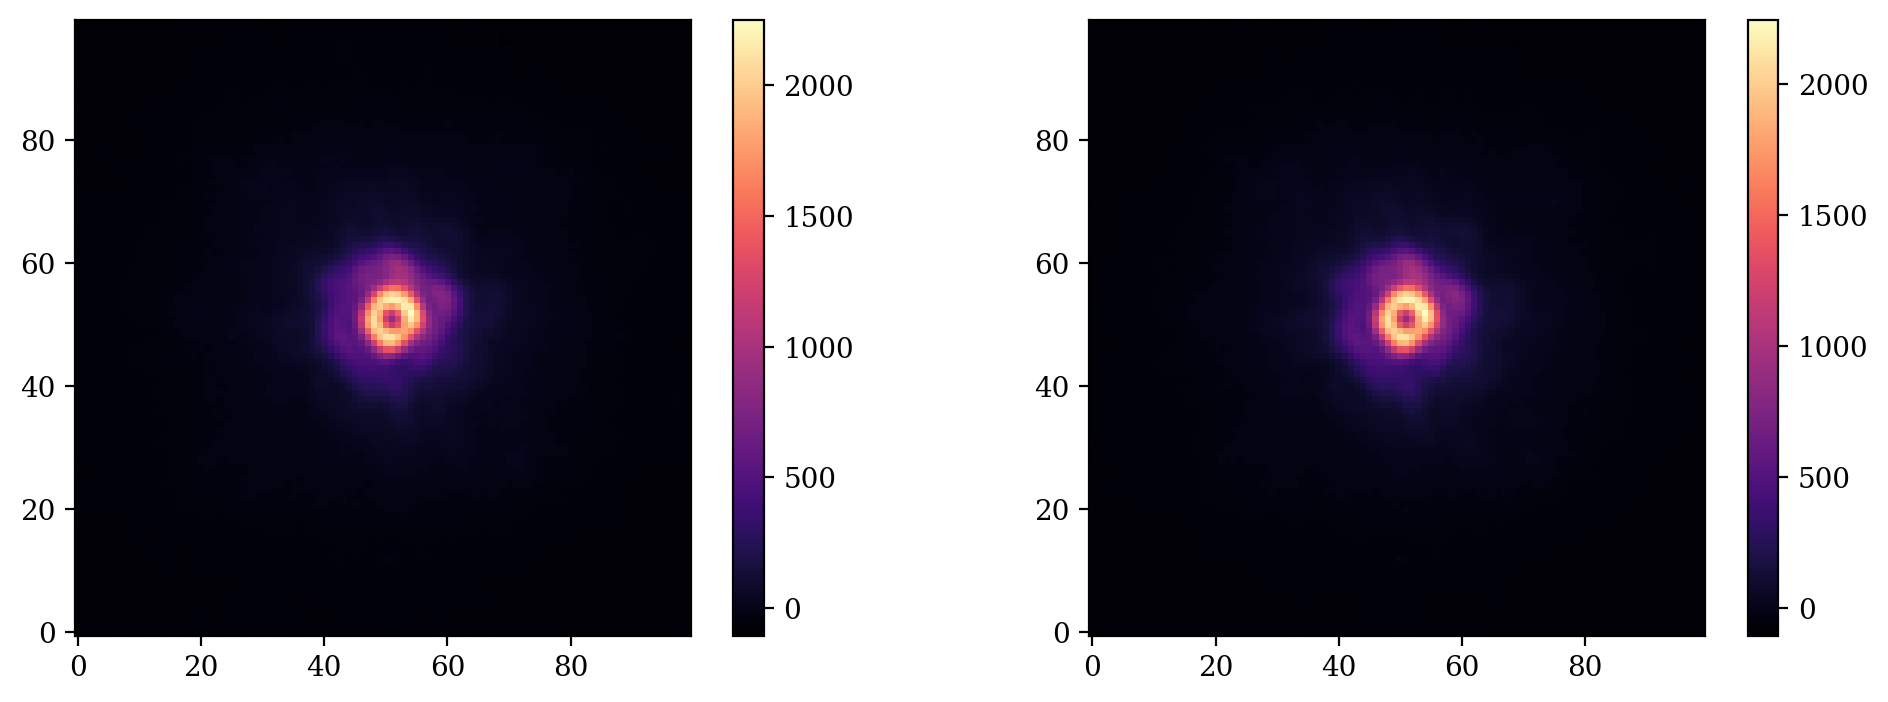

In [283]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(target.reshape(image_shape))
plt.colorbar()
plt.subplot(122)
plt.imshow(Ihat_psi0_slow.reshape(image_shape))
plt.colorbar()

Looks reasonable.

The reader may once again observe that projections and summations can be readily expressed with matrix operations. The dot products of $T$ with all $K_\text{klip}$ eigenvectors can be expressed as a $K_\text{klip}$-dimensional vector $v = (Z^\text{KL})^T T$.

In [285]:
(Z_KL_truncated.T @ target).shape

(30,)

We then form a linear combination of the columns of $Z^\text{KL}$ with the projection vector, which is just $Z^\text{KL} v$.

So, the full PSF reconstruction can be written: $\hat{I}_{\psi_0} = Z^\text{KL} ((Z^\text{KL})^T T)$

**Note:** if you don't use parentheses to force NumPy to evaluate $Z^\text{KL} ((Z^\text{KL})^T T)$ rather than $(Z^\text{KL} (Z^\text{KL})^T) T$, it will create an $N \times N$ intermediate matrix rather than a $K_\text{klip}$ dimensional intermediate vector. This can make a big difference in runtime and memory use!

In [287]:
%%timeit
(Z_KL_truncated @ Z_KL_truncated.T) @ target

1.77 s ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [288]:
%%timeit
Z_KL_truncated @ (Z_KL_truncated.T @ target)

1.11 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This gives us $\hat{I}_{\psi_0}$ in one line of Python:

In [290]:
Ihat_psi0 = Z_KL_truncated @ (Z_KL_truncated.T @ target)

## Step 5: Calculate the Final Image
Easy: subtract our `Ihat_psi0` from our `target` and reshape it for display:

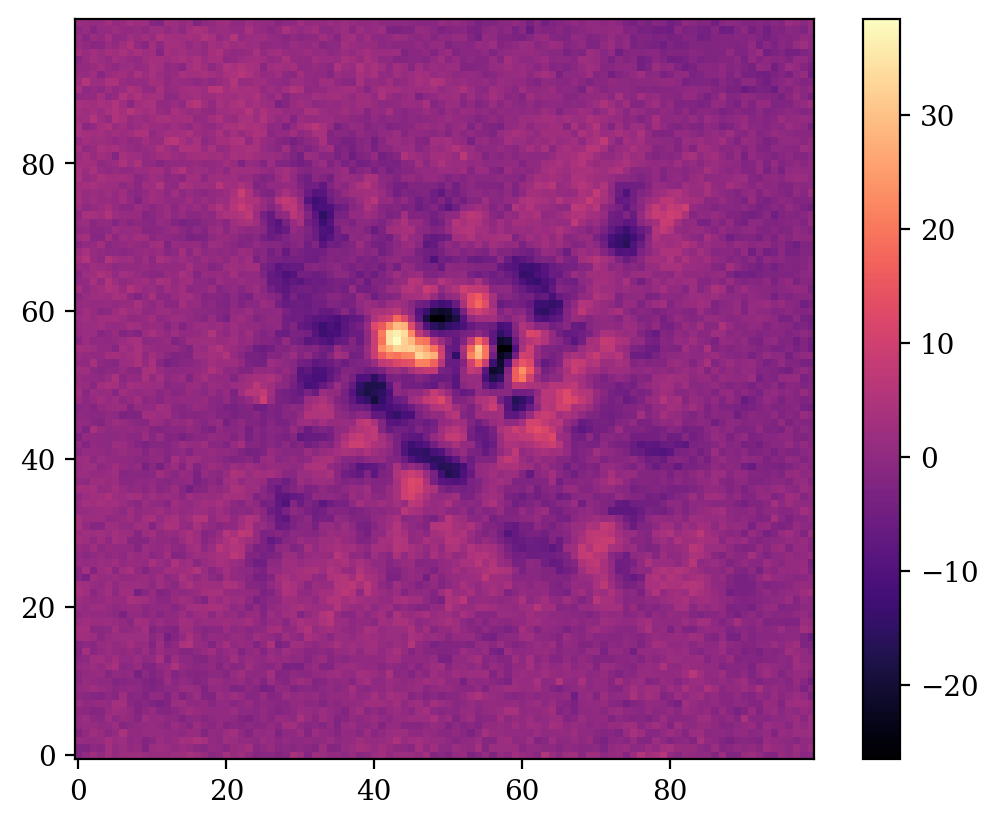

In [292]:
plt.imshow((target - Ihat_psi0).reshape(image_shape))
plt.colorbar()

It's not totally obvious what we're seeing here. Clearly there is still residual starlight, and we didn't expect to see the planet in a single frame from ground based data. How do we know we did it right?

These data depend on angular differential imaging (ADI) to decorrelate planet signal from speckles, so co-adding the starlight subtracted frames naively still would not help, as we'd be smearing our planet signal over a whole arc of pixels.

It is quite easy to apply the last step to combine KLIP with ADI, revealing an exoplanet!

# Apply KLIP and ADI

Since this is an angular differential imaging dataset, we starlight-subtract our frames individually before rotating them to a common orientation and combining them.

Properly applying KLIP and ADI would require recomputing the $Z^\text{KL}$ basis 61 times for the 61 different images in the dataset that each take a turn as $T$, the target. The construction of the reference set $R$ leaving out $T$ would produce a different $E_{RR}$ and a different set of eigenvectors each time. (For fans of big-$O$ notation, yes, this increases the exponent by one, making a nominally $O(N^3)$ algorithm into $O(N^4)$!)

As we're just trying to demonstrate the application of KLIP, we can compute a single Karhunen-Loève basis from all the observations without that additional complication and still see something interesting.

The dataset from NACO includes an array `naco_betapic_preproc['angles']` representing the parallactic angle of the observation.

Text(0, 0.5, 'Parallactic angle [deg]')

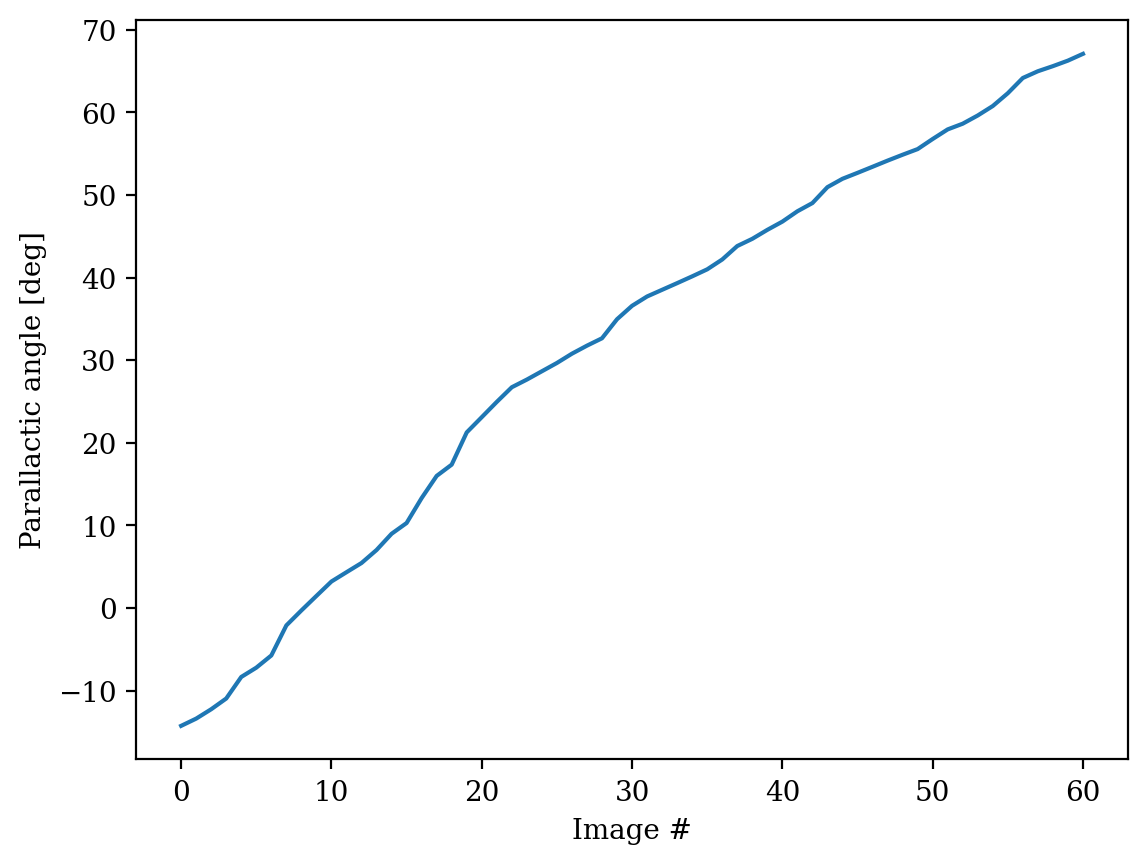

In [294]:
plt.plot(naco_betapic_preproc['angles'])
plt.xlabel('Image #')
plt.ylabel('Parallactic angle [deg]')

 We can bring in `rotate()` from scikit-image to (de-)rotate our starlight-subtracted images before combination.

In [298]:
from skimage.transform import rotate

Now, putting it all together:

In [300]:
# wrapped in a function to not clobber existing variables with these names...
def klip_and_derotate(K_klip):
    # Step 1a, already mean-subtracted
    reference = frame_vecs_meansub
    # Step 2: compute KL transform
    E = reference @ reference.T
    lambda_values_out, C_out = np.linalg.eigh(E)
    lambda_values = np.flip(lambda_values_out)
    C = np.flip(C_out, axis=1)
    Z_KL = reference.T @ (C * np.power(lambda_values, -1/2))
    # Step 3: passed in as K_klip
    Z_KL_truncated = Z_KL[:,:K_klip]
    # Steps 4 and 5 are computed once per frame in the sequence
    derotated_image = np.zeros(image_shape)
    for i in range(frame_vecs_meansub.shape[0]):
        # Step 4: compute the estimate of I
        target = frame_vecs_meansub[i]
        Ihat_psi0 = Z_KL_truncated @ (Z_KL_truncated.T @ target)
        # Step 5: subtract the estimate from the target image
        residual = target - Ihat_psi0
        residual_image = residual.reshape(image_shape)
        # Derotate and add to final KLIP+ADI result
        derotated_image += rotate(residual_image, -naco_betapic_preproc['angles'][i])
    return derotated_image

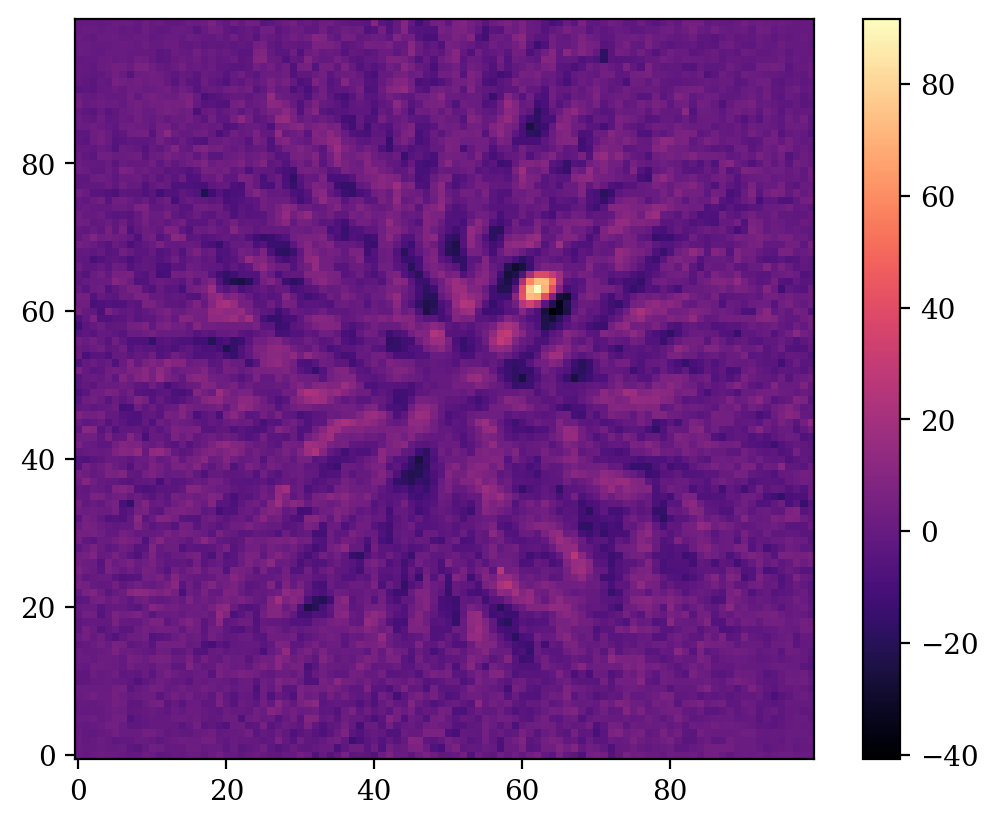

In [301]:
plt.imshow(klip_and_derotate(30))
plt.colorbar()

Look at that! We found our planet! [$\beta$ Pictoris b](https://en.wikipedia.org/wiki/Beta_Pictoris_b)!

As promised, we can now explore the effects of varying $K_\text{klip}$ on ADI data.

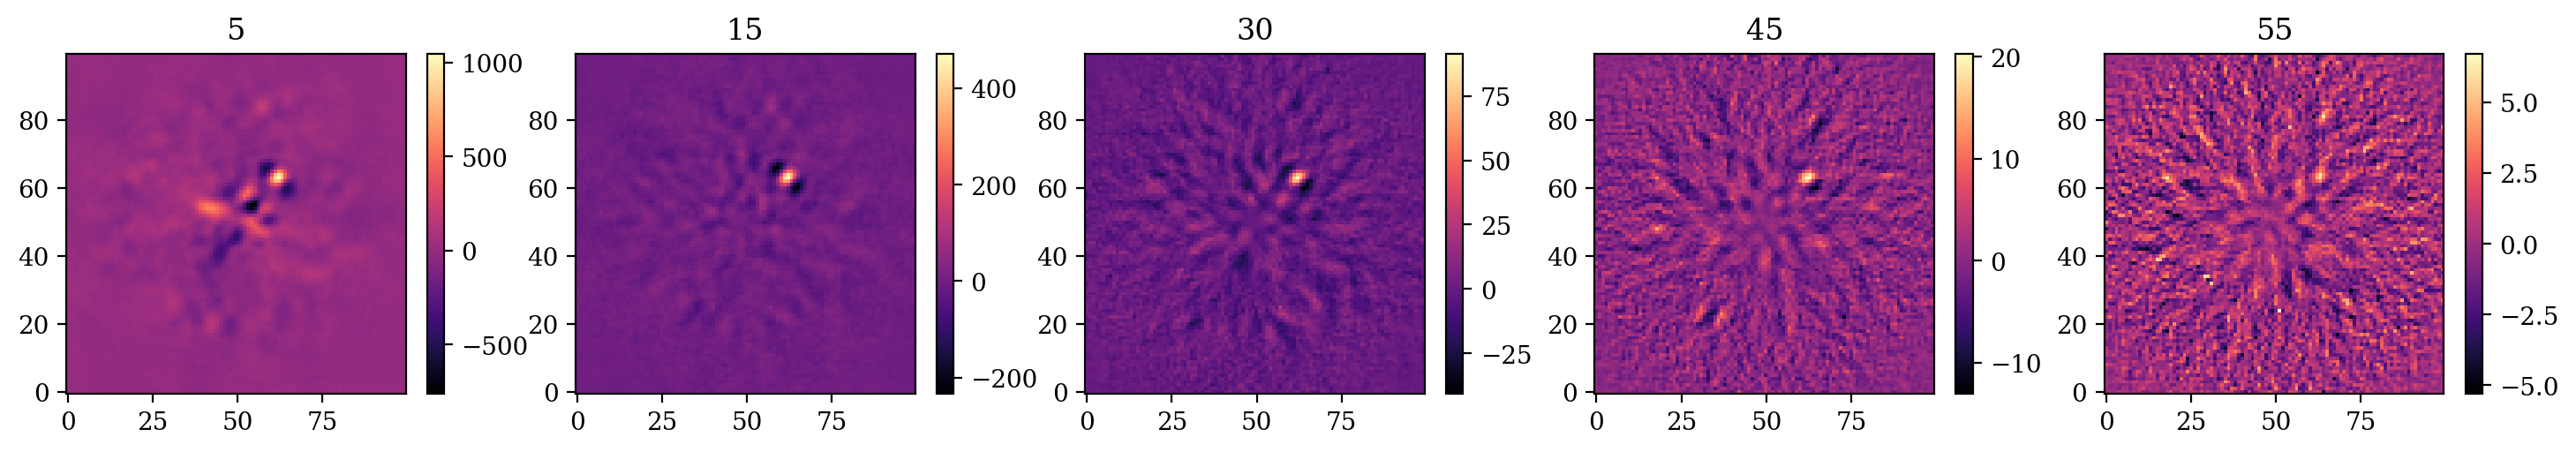

In [303]:
plt.figure(figsize=(18, 2.5))
for idx, current_K_klip in enumerate([5, 15, 30, 45, 55]):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(klip_and_derotate(current_K_klip))
    plt.colorbar()
    plt.title(current_K_klip)

# Optimizing $K_\text{klip}$ and measuring signal-to-noise

As we can see, more modes are not necessarily better. If you watch the color bars, the peak of the planet decreases dramatically as $K_\text{klip}$ increases and retaining 55 modes from our 61 reference PSFs subtracts almost all of the exoplanet signal. The quantity we want to optimize is not the peak planet brightness, nor the noise level in counts, but the signal-to-noise **ratio**. Clearly, some $5 < K_\text{klip} < 55$ produces the most signal from this dataset.

Regrettably, this computation involves **even more** tedious bookkeeping than the starlight subtraction itself, but it's not terribly difficult. We just repeat our starlight subtraction at each possible $K_\text{klip}$, measure our signal-to-noise ratio, and choose the best one.

First, we need a rough location for our planet in pixels. We express it in radius (in pixels) and position angle (degrees East of North, a.k.a. counter-clockwise from +Y).

(18.398369492974098, -42.797401838234194)

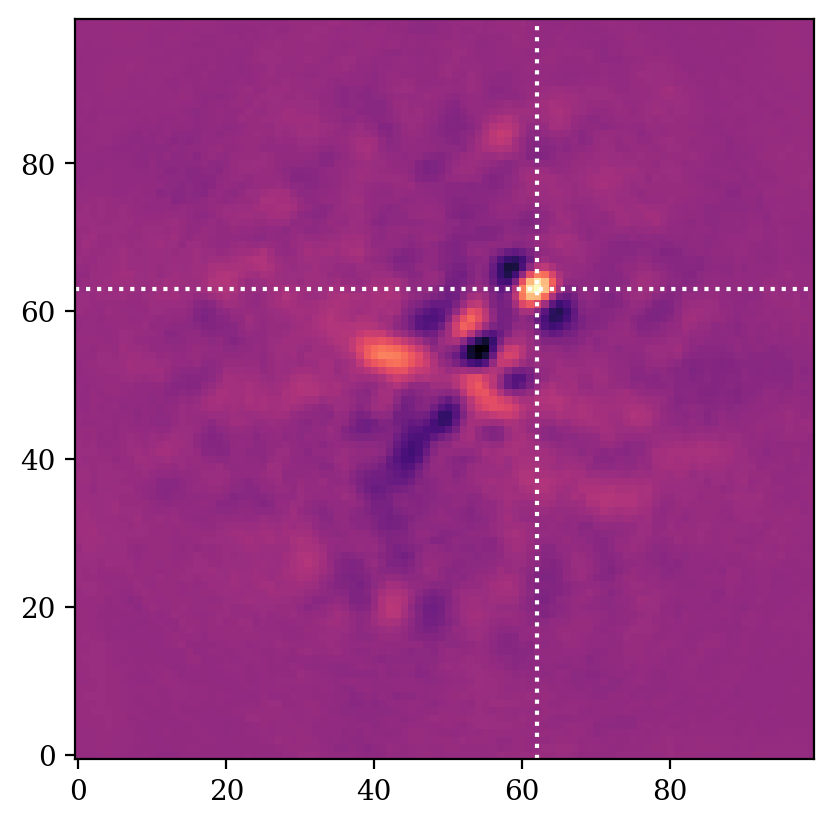

In [306]:
plt.imshow(klip_and_derotate(5))

# show crosshairs on planet
planet_x, planet_y = 62, 63
plt.axhline(planet_y, c='w', ls=':')
plt.axvline(planet_x, c='w', ls=':')

# convert to r and degrees E of N (CCW from +Y)
ctr = (image_shape[0] - 1) / 2
planet_dx, planet_dy = planet_x - ctr, planet_y - ctr
r_px, pa_deg = (
    np.hypot(planet_dx, planet_dy),
    np.rad2deg(np.arctan2(planet_dy, planet_dx)) - 90
)
r_px, pa_deg

The next step is to define a ring of apertures around the star (image center) to measure signal and noise. This is just geometry, $(x, y) = (r \cos \theta, r \sin \theta)$ stuff.

In [308]:
def simple_aperture_locations(r_px, pa_deg, resolution_element_px, 
                              exclude_nearest=0, exclude_planet=False):
    '''Generator yielding aperture centers (x, y) in a ring of radius `r_px`
    and starting at angle `pa_deg` E of N. Unless `exclude_planet` is True,
    the first (x, y) pair gives the planet location (signal aperture).
    
    Specifying `exclude_nearest` > 0 will skip that many apertures 
    from either side of the signal aperture's location'''
    circumference = 2 * r_px * np.pi
    aperture_pixel_diameter = resolution_element_px
    n_apertures = int(circumference / aperture_pixel_diameter)
    start_theta = np.deg2rad(pa_deg + 90)
    delta_theta = np.deg2rad(360 / n_apertures)
    if not exclude_planet:
        yield (r_px * np.cos(start_theta),
               r_px * np.sin(start_theta))
    for i in range(1 + exclude_nearest, n_apertures - exclude_nearest):
        offset_x, offset_y = (
            r_px * np.cos(start_theta + i * delta_theta),
            r_px * np.sin(start_theta + i * delta_theta)
        )
        yield offset_x, offset_y

The size of the aperture should be approximately a resolution element, which for this dataset I just [happen to know](https://github.com/carlgogo/VIP_extras/blob/master/tutorials/01_adi_pre-postproc_fluxpos_ccs.ipynb) is about 4 pixels.

In [313]:
fwhm_naco = 4

It'll help to see them:

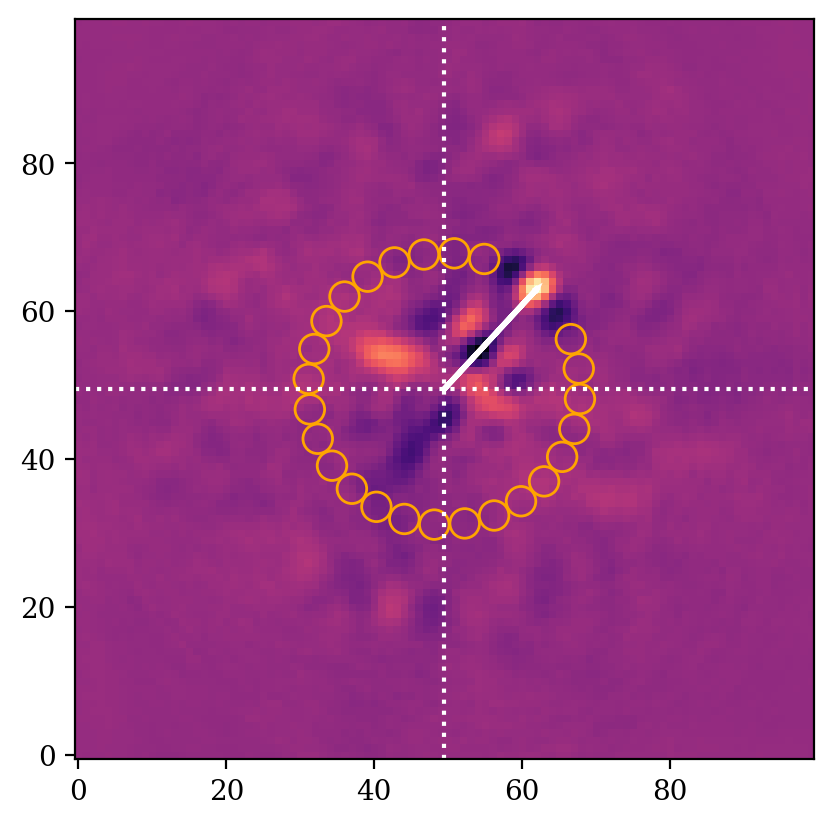

In [315]:
def show_simple_aperture_locations(image, resolution_element_px, r_px, pa_deg, 
                                   exclude_nearest=0, exclude_planet=False, ax=None):
    '''Plot `image` and overplot the circular apertures of diameter 
    `resolution_element_px` in a ring at radius `r_px`
    starting at `pa_deg` E of N.
    '''
    if ax is None:
        ax = plt.gca()
    ctr = (image.shape[0] - 1) / 2
    im = ax.imshow(image)
    ax.axhline(ctr, color='w', linestyle=':')
    ax.axvline(ctr, color='w', linestyle=':')
    planet_dx, planet_dy = r_px * np.cos(np.deg2rad(90 + pa_deg)), r_px * np.sin(np.deg2rad(90 + pa_deg))
    ax.arrow(ctr, ctr, planet_dx, planet_dy, color='w', lw=2)
    for offset_x, offset_y in simple_aperture_locations(r_px, pa_deg, resolution_element_px, exclude_nearest=exclude_nearest, exclude_planet=exclude_planet):
        ax.add_artist(plt.Circle(
            (ctr + offset_x, ctr + offset_y),
            radius=resolution_element_px/2,
            edgecolor='orange',
            facecolor='none',
        ))

show_simple_aperture_locations(
    klip_and_derotate(5), 
    fwhm_naco, 
    r_px, 
    pa_deg, 
    exclude_planet=True, 
    exclude_nearest=1
)

To do our simple aperture photometry, we'll need a helper for the cartesian coordinates at each pixel.

In [320]:
def cartesian_coords(center, data_shape):
    '''center in x,y order; returns coord arrays xx, yy of data_shape'''
    yy, xx = np.indices(data_shape, dtype=float)
    center_x, center_y = center
    yy -= center_y
    xx -= center_x
    return xx, yy

Now, for every one of our apertures, we want to do something to the pixels inside it.

In [322]:
def reduce_apertures(image, r_px, starting_pa_deg, resolution_element_px, operation, 
                     exclude_nearest=0, exclude_planet=False):
    '''apply `operation` to the pixels within radius `resolution_element_px`/2 of the centers
    of the simple aperture locations for a planet at `r_px` and `starting_pa_deg`, returning
    the locations and the results as a tuple with the first location and result corresponding
    to the planet aperture'''
    center = (image.shape[0] - 1) / 2, (image.shape[0] - 1) / 2
    xx, yy = cartesian_coords(center, image.shape)
    locations = list(simple_aperture_locations(r_px, starting_pa_deg, resolution_element_px, exclude_nearest=exclude_nearest, exclude_planet=exclude_planet))
    simple_aperture_radius = resolution_element_px / 2
    results = []
    for offset_x, offset_y in locations:
        dist = np.sqrt((xx - offset_x)**2 + (yy - offset_y)**2)
        mask = dist <= simple_aperture_radius
        results.append(operation(image[mask]))
    return locations, results

Compute the total signal and the set of noise measurements:

In [325]:
locations, results = reduce_apertures(
    klip_and_derotate(5),
    r_px,
    pa_deg,
    fwhm_naco,
    np.average
)

Note that we've passed `np.average` as our reduction operation. That means our estimate of the signal is independent of the number of pixels in the circular aperture, which can vary as we go around the circle because of the imprecision in drawing a circle with a discrete pixel grid.

In [327]:
planet_signal, noise_measurements = results[0], results[1:]

The signal-to-noise ratio defined in [Mawet _et al._ (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract) is based on the two-sample Student $t$ test to account for the fact that at small separations, very few apertures will fit in the ring. Using their equation 9 we have

$$
    \text{SNR} = \frac{
        \bar{x}_1 - \bar{x}_2
    }{
        s_2 \sqrt{1 + \frac{1}{n_2}}
    }
$$

where $\bar{x}_1$ is the mean of the signal measurements (i.e. the value of the signal aperture sum), $\bar{x}_2$ the mean of the noise measurements (the mean of the noise aperture sums), $s_2$ is the empirical standard deviation of the noise measurements, and $n_2$ is the number of noise measurements in the set.

In [329]:
def calc_snr_mawet(signal, noises):
    '''Calculate signal to noise following the 
    two-sample t test as defined in Mawet 2014'''
    return (
        signal - np.average(noises)
    ) / (
        np.std(noises) * np.sqrt(1 + 1/len(noises))
    )

In [330]:
calc_snr_mawet(planet_signal, noise_measurements)

6.873799731435254

Now we loop over values for $K_\text{klip} \in [5, 55)$ and see how the signal-to-noise behaves. (I'm also excluding one aperture on either side of the planet location.)

Text(0, 0.5, 'SNR')

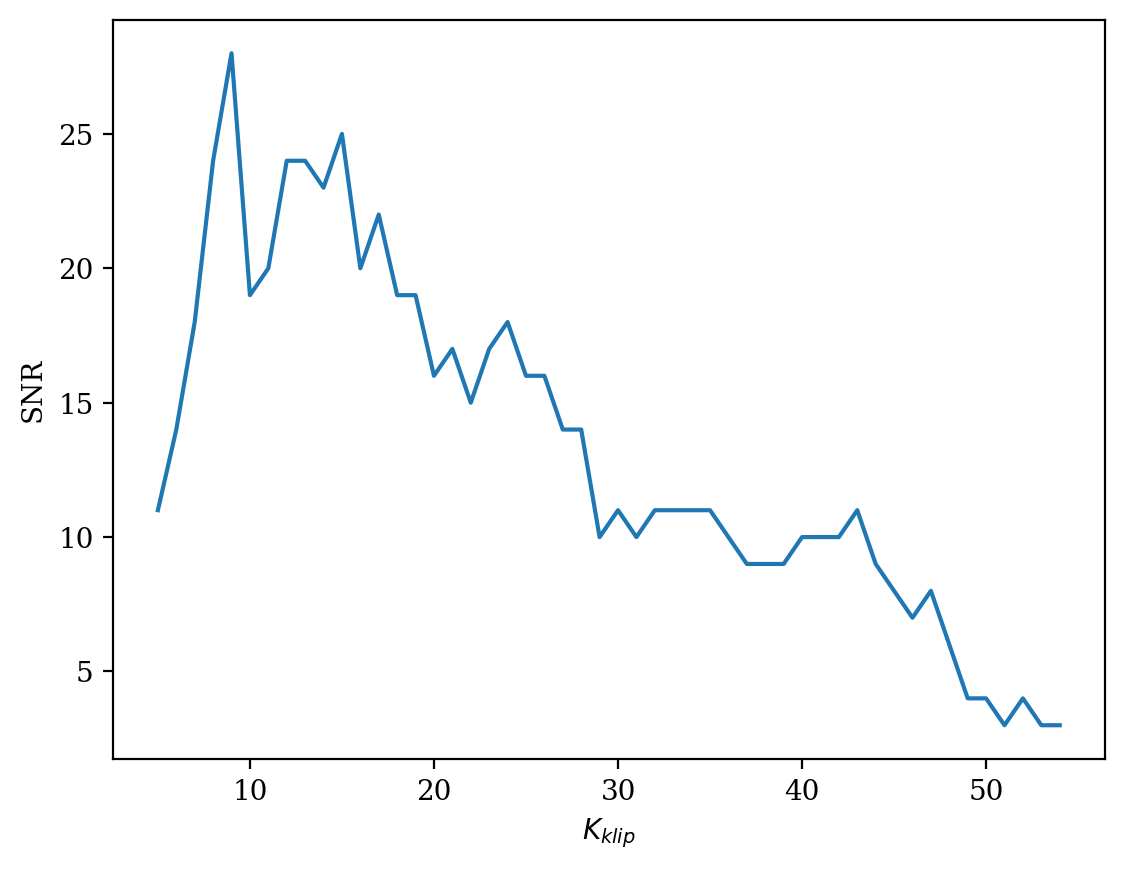

In [332]:
K_klip_vals = np.arange(5, 55)
snrs = np.zeros_like(K_klip_vals)

for idx, K_klip in enumerate(K_klip_vals):
    detection_image = klip_and_derotate(K_klip)
    locations, results = reduce_apertures(
        detection_image, 
        r_px, 
        pa_deg, 
        fwhm_naco, 
        np.sum, 
        exclude_nearest=1
    )
    planet_signal, noise_measurements = results[0], results[1:]
    snrs[idx] = calc_snr_mawet(planet_signal, noise_measurements)

plt.plot(K_klip_vals, snrs)
plt.xlabel(r'$K_{klip}$')
plt.ylabel('SNR')

Selecting the optimal $K_\text{klip}$ is then:

In [334]:
optimal_K_klip = K_klip_vals[np.argmax(snrs)]
optimal_K_klip

9

And then we can visualize the result:

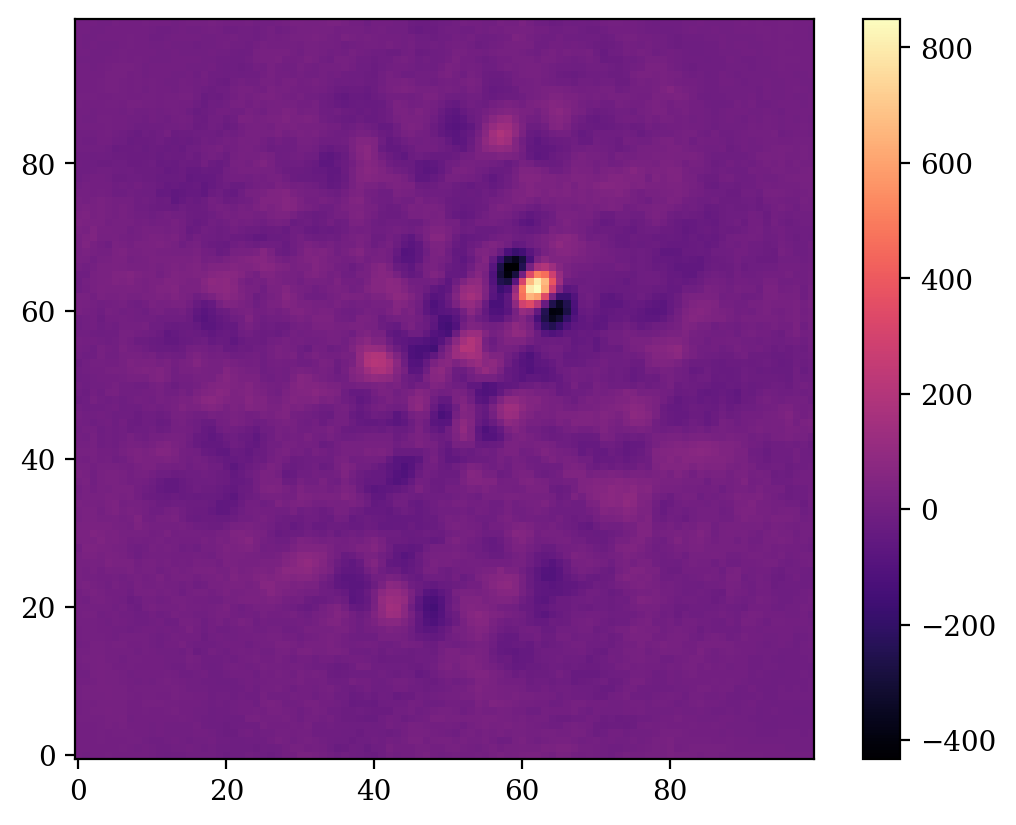

In [336]:
plt.imshow(klip_and_derotate(optimal_K_klip))
plt.colorbar()

# The Case of the Missing Precision

We have 61 references in $R$, meaning $Z^\text{KL}$ contains 61 eigenimages. What happens if we try to subtract all 61 modes?

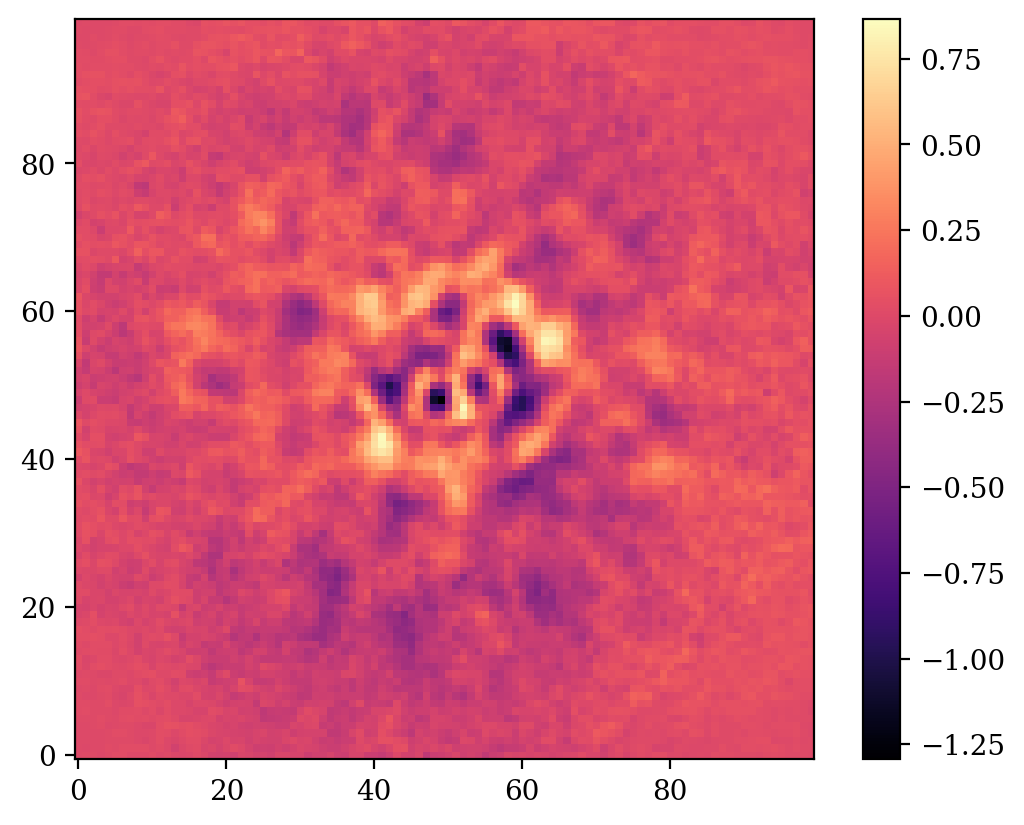

In [339]:
plt.imshow(klip_and_derotate(61))
plt.colorbar()

That's weird. Why is it not identically zero across the image? We established above that transforming an observation to the KL basis and back is possible without loss of information.

In the world of math, that would be true, but it turns out that we've lost numerical precision along the way. Forming the covariance matrix $E$ loses precision when small values are added to large ones. Computing the eigenimages from the covariance eigenvectors compounds this error. Then, of course, we're rotating each frame by a different amount, creating the nice circular patterns.

While it's not useful to subtract all possible modes from a dataset when the reference set contains the target image, it's an interesting diagnostic of the numerical error we're accumulating. Can we do better?

Without going into the math, we can obtain the same eigenimages from a singular value decomposition of the data.

In [344]:
u, s, vt = np.linalg.svd(frame_vecs_meansub, full_matrices=False)
Z_KL_svd = vt.T

Repeating the above procedure, we use the right singular vectors of the data as our KL basis:

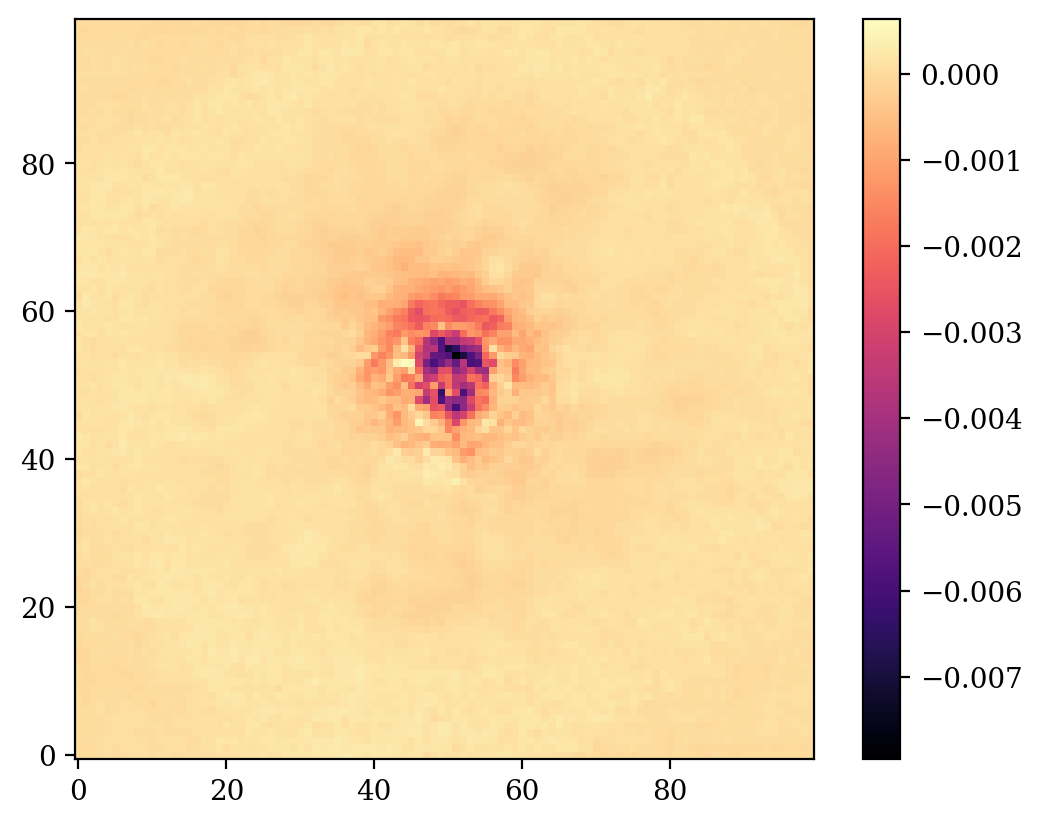

In [346]:
derotated_image = np.zeros(image_shape)
for i in range(frame_vecs_meansub.shape[0]):
    # Step 4: compute the estimate of I
    target = frame_vecs_meansub[i]
    Ihat_psi0 = Z_KL_svd @ (Z_KL_svd.T @ target)
    # Step 5: once for each target image
    residual = target - Ihat_psi0
    residual_image = residual.reshape(image_shape)
    # Bonus: combine derotated image to generate final KLIP+ADI result
    derotated_image += rotate(residual_image, -naco_betapic_preproc['angles'][i])

plt.imshow(derotated_image)
plt.colorbar()

There's still structure in the residuals, but if we compare them on the same color scale it becomes obvious just how much smaller they are:

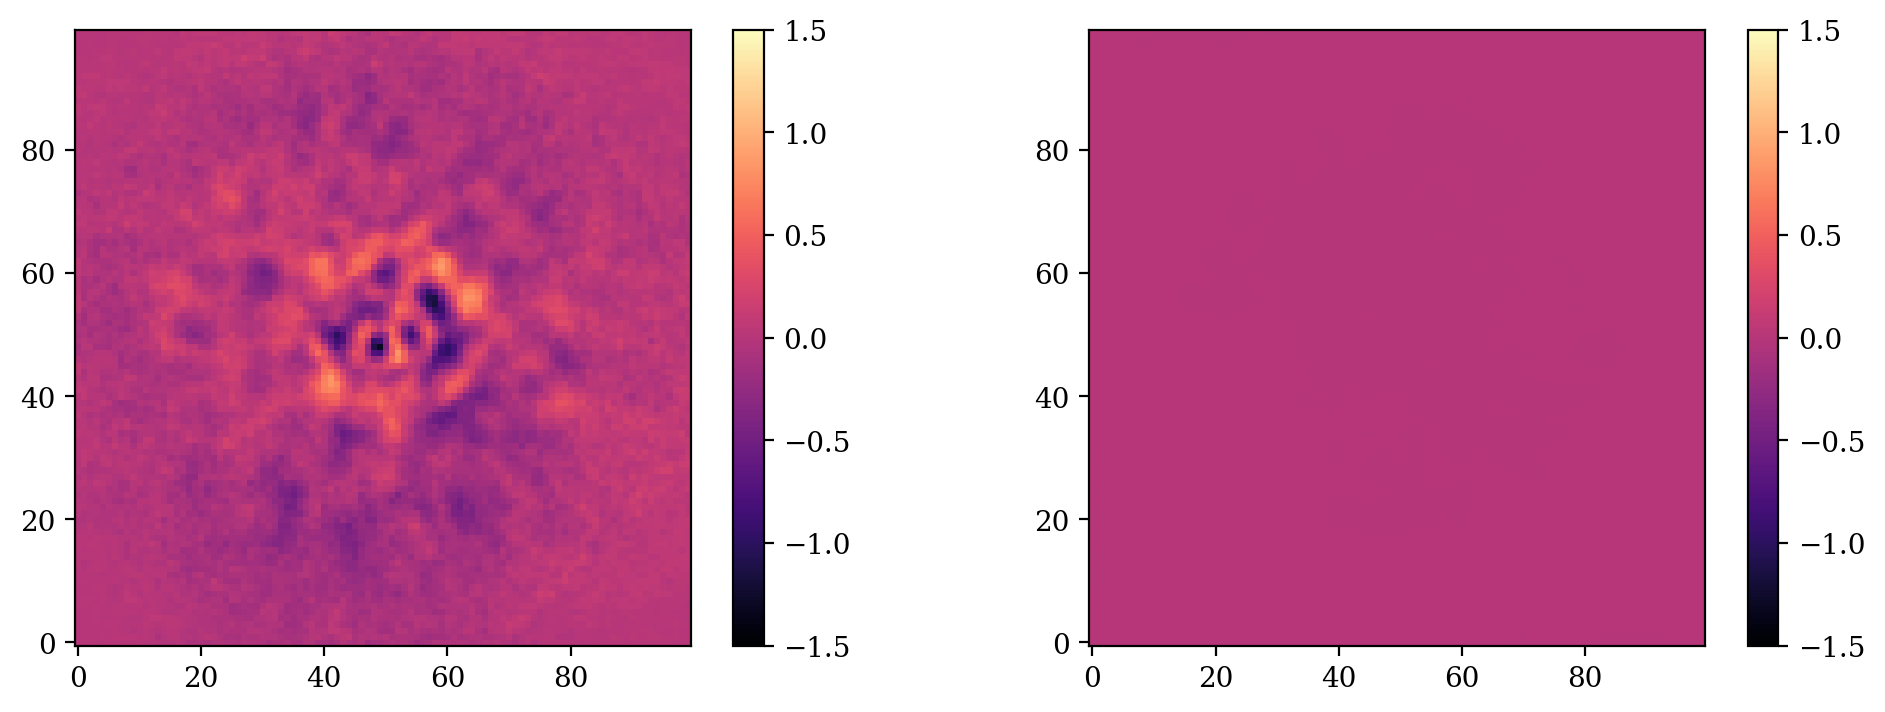

In [348]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(klip_and_derotate(61), vmin=-1.5, vmax=1.5)
plt.colorbar()
plt.subplot(122)
plt.imshow(derotated_image, vmin=-1.5, vmax=1.5)
plt.colorbar()

Four orders of magnitude is not a bad improvement! Why don't we do this all the time?

It's all about runtime:

In [350]:
E = reference @ reference.T
%timeit np.linalg.eigh(E)

8.36 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [351]:
%timeit np.linalg.svd(reference, full_matrices=False)

152 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Okay, so the SVD is slower. How much slower?

Computing the eigenvectors of an $n \times n$ matrix [costs roughly $O(n^3)$ in time](https://cstheory.stackexchange.com/a/2810), and the SVD of an $m \times n$ matrix (where $m > n$) [costs $O(mn^2)$](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra). 

Our covariance matrix is $K \times K$, where $K$ the number of observations we have. (Cost: $O(K^3)$.) The long dimension of our PSF references matrix is $N$, the number of pixels in the image. (Cost: $\min (O(NK^2), O(KN^2))$, since the solver transparently transposes and swaps the left and right singular vectors when it would be faster.) So long as $K \ll N$, it will be advantageous to compute the image-to-image covariance first.

When might that not be true?

In this notebook, we've used all 10,000 pixels from the example NACO data, so $N = N_S = 10000$. In practice, it's possible to optimize the starlight subtraction of particular regions of the image using a matrix of image vectors containing just the pixels in that region, potentially reducing $N$ dramatically.

At some sufficiently large $K$ it will be faster to compute the SVD of $R$ than the eigenvectorization of $E_{RR}$. Where that cutoff is exactly will vary based on hardware and implementation, but the SVD will always win in the limit as $K \rightarrow \infty$ at constant $N$.

# Conclusion

Hopefully this has demystified starlight subtraction. For the working astronomer's day-to-day use, I recommend [PyKLIP](https://pyklip.readthedocs.io/en/latest/install.html), [VIP](https://vip.readthedocs.io/), or [PYNPOINT](https://quanz-group.ethz.ch/research/algorithms/pynpoint.html). However, it's always a good idea to know how your tools work!

It's not that hard to discover $\beta$ Pic b, especially when you already know it's there.

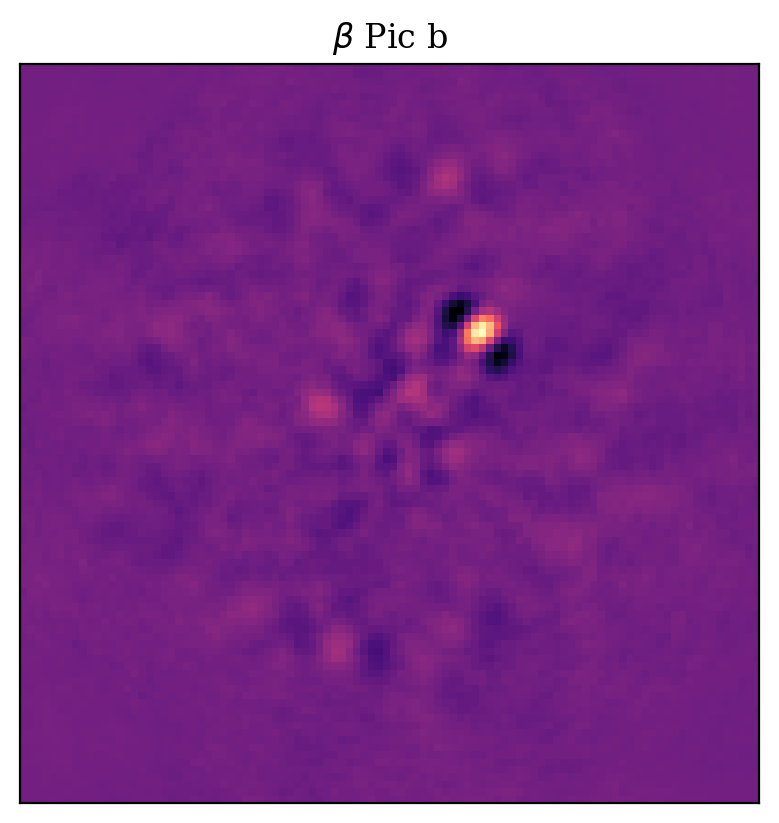

In [354]:
plt.imshow(klip_and_derotate(optimal_K_klip))
plt.title('$\\beta$ Pic b')
plt.xticks([])
_ = plt.yticks([])